In [143]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
from datetime import date
import yfinance as yf
from datetime import datetime, timedelta


In [144]:
def realizagranger(df, maxlag=6, epsilon=0.01, sel1="HRV", sel2="HRV"):
    try:
        if len(df) <= maxlag:
            
            print(f"{len(df)} Datos insuficientes?.")
            return 0
        
        # Realizar la prueba de causalidad de Granger
        gc_test_1 = grangercausalitytests(df[[sel1, sel2]], maxlag=maxlag, verbose=False);
        p_values = [gc_test_1[i + 1][0]['ssr_chi2test'][1] for i in range(maxlag)]
        
        # Verificar si la media de los p-valores es menor que el umbral
        for val in p_values:
            if val < epsilon:
                return 1
        return 0
        #return int(np.mean(p_values) < pval)
        
    except Exception as e:
        print(f"Error en ventana {e}")
        return 0

def crea_matriz(df, maxlag=6, epsilon=0.01):
    matriz = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            if i != j:
                matriz[i, j] = realizagranger(df, sel1=df.columns[i], sel2=df.columns[j], maxlag=maxlag, epsilon=epsilon)
    return matriz

In [145]:
df_precios = pd.DataFrame()

# Acciones
activos = ['ALSEA.MX','GRUMAB.MX','GCARSOA1.MX', 'AMXB.MX', 'CUERVO.MX', 'BOLSAA.MX',
          'GFINBURO.MX','KOFUBL.MX','HERDEZ.MX', 'Q.MX', 'BIMBOA.MX' ]

# Numero de acciones
n = len(activos)

today = date.today()
start = today - timedelta(weeks=13)

print(today)

for i in activos:
    df_precios[i] = pd.DataFrame(yf.Ticker(i).history(start = start,end = today, )['Close'])
    
df_precios.head(10)
df_precios.fillna(method='ffill', inplace=True)

2024-12-26


C:\Users\fercy\AppData\Local\Temp\ipykernel_22224\1932335774.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_precios.fillna(method='ffill', inplace=True)


In [146]:
# Aparentemente descansa feriados y fines de semana

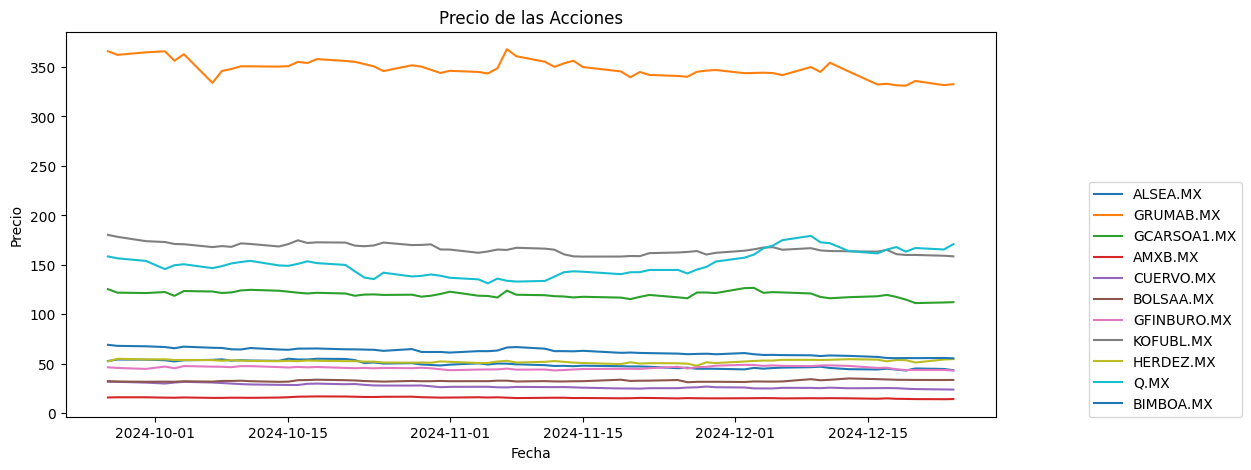

In [164]:
plt.figure(figsize = (12,5))
for i in df_precios.columns.values:
    plt.plot(df_precios[i], label = i)
plt.title('Precio de las Acciones')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(df_precios.columns.values, loc = [1.1,0])
plt.show()

In [148]:
df_precios.shape

(61, 11)

# Causalidad de Granger

* Se utilizan modelos autoregresivos para determinar si los pesos de una señal en el pasado X pueden usarse para mejorar la predicción de valores futuros de Y.

* Es un método ya usado en la econometría

* El objetivo de aquí es determinar de acuerdo a N numero de activos cuales estan relacionados y la dirección de esa relación

* Con esto pretendo obtener los activos que tengan mayor influencia de otros para usar esos otros activos y predecir el activo en cuestion

In [ ]:
matriz_causalidad = crea_matriz(df_precios, maxlag = 8, epsilon = 0.01);

<Axes: >

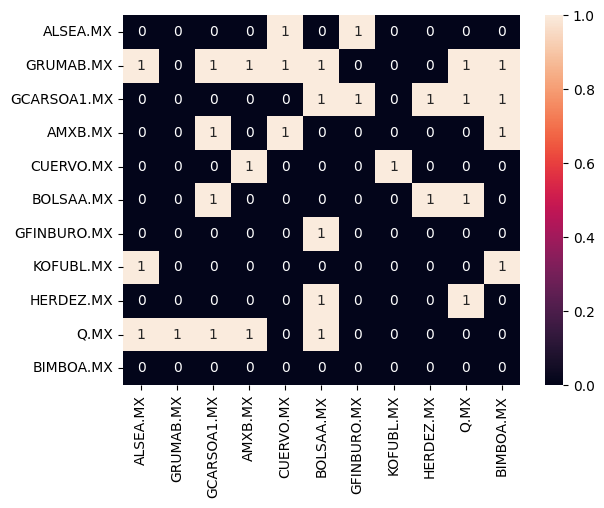

In [150]:
sns.heatmap(matriz_causalidad, xticklabels=df_precios.columns, yticklabels=df_precios.columns, annot=True)

# Análisis de Redes

A partir de la matriz de causalidad se genera una red de Nodos (Activos) los cuales tienen una dirección de causalidad hacia otros nodos

In [151]:
import networkx as nx

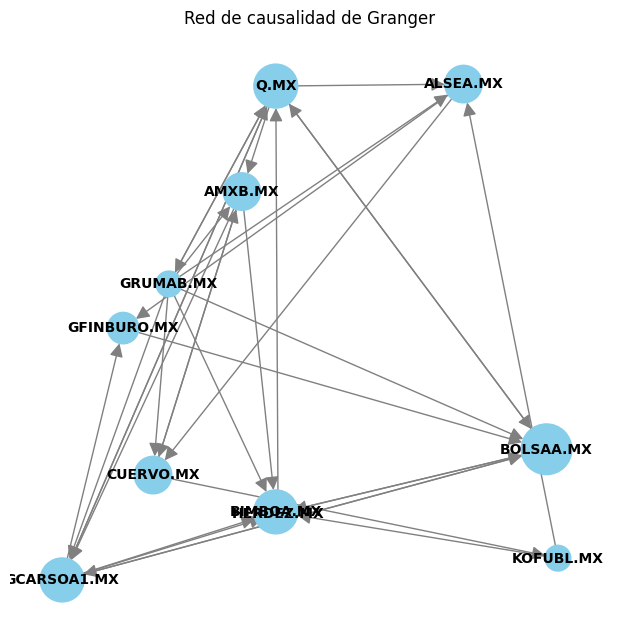

In [152]:
G = nx.DiGraph()  

labels = df_precios.columns

for i in range(len(matriz_causalidad)):
    for j in range(len(matriz_causalidad[i])):
        if matriz_causalidad[i][j] == 1:  
            G.add_edge(labels[i], labels[j])

for label in labels:
    if label not in G:
        G.add_node(label)

in_degrees = dict(G.in_degree())
node_sizes = [(in_degrees[node] + 6) ** 3 for node in G.nodes()]  

plt.figure(figsize=(6, 6))
pos = nx.random_layout(G) 
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', arrows=True, arrowsize=20)
plt.title('Red de causalidad de Granger')
plt.show()


de aquí se pueden sacar varias cosas...

ejemplos

* ¿Cuales son los activos que influyen directamente a la Bolsa Mexicana de valores?
* ¿Qué activos están relacionados entre sí?
    - No es sorpresa que america movil (AMXB) influya sobre grupo carso (GCARSOA1)
* ¿Que activos son los más aislados del conjunto que se definió?


Utilizando diferentes métricas de análisis de la red se pueden descubrir más cosas de la red

 * Input Degree: Mide el número de conexiones entrantes a un nodo, indicando el grado en que un nodo (o región del cerebro) es influenciado por otros. 
 * Output Degree: Representa el número de conexiones salientes desde un nodo, reflejando cuánto influye el nodo en otros nodos de la red. 
 * Betweenness Centrality: Cuantifica la importancia de un nodo como puente en los caminos más cortos entre otros nodos, destacando su papel en facilitar la comunicación dentro de la red. 
 * Clustering Coefficient: Evalúa la tendencia de los vecinos de un nodo a formar conexiones entre sí, proporcionando información sobre la cohesión local de la red.
 por mensionar algunos.

si, hay mucho más...

## La métrica que quiero tomar en cuenta es el input degree


* se define como el número de nodos de entra a otro nodo

* mientras más alto sea quiere decir que es predecible por más nodos

* en este contexto puede significar que las acciones de un activo son predecibles por las acciones pasada de otro activo

Esta métrica se ve reflejada en el tamaño de los nodos de la red

Pero esa predicción será para otro notebook...

In [153]:
in_degrees

{'ALSEA.MX': 3,
 'CUERVO.MX': 3,
 'GFINBURO.MX': 2,
 'GRUMAB.MX': 1,
 'GCARSOA1.MX': 4,
 'AMXB.MX': 3,
 'BOLSAA.MX': 5,
 'Q.MX': 4,
 'BIMBOA.MX': 4,
 'HERDEZ.MX': 2,
 'KOFUBL.MX': 1}

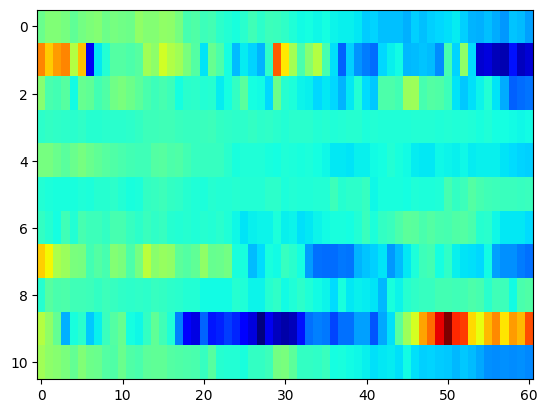

In [154]:
plt.imshow(((df_precios - df_precios.mean()).T), aspect='auto', cmap='jet')

# Formación de Subredes

A partir de esta red se pueden formar subredes. Las subredes que voy a formar son las siguientes:

* Minimo Riesgo
* Máximo Riesgo

In [155]:
from portfoliotools import *

In [156]:
portfolio_max = calcular_portafolio(df_precios, 500, objetivo='max_sharpe', verbose=False)

# Si el % de capital es menor o mayor al 1%, se considerará que ese activo tiene una participación marginal o nula en el portafolio.

umbral = 5

for i in range(len(portfolio_max)):
    if np.abs(portfolio_max["% Capital"][i]) < umbral:
        portfolio_max.drop(i, inplace=True)
portfolio_max.reset_index(drop=True, inplace=True)
portfolio_max

,Activos,Precio,# Activos,Monto,% Capital
0,ALSEA.MX,43.509998,2,87.019997,17.599499
1,GCARSOA1.MX,112.320000,0,0.000000,5.779022
2,CUERVO.MX,23.969999,7,167.789995,38.306298
3,KOFUBL.MX,158.649994,1,158.649994,41.676097
4,Q.MX,170.940002,-1,-170.940002,-17.113533
5,BIMBOA.MX,55.540001,2,111.080002,22.303324


In [157]:
portfolio_min = calcular_portafolio(df_precios, 500, objetivo='min_var', verbose=False)
umbral = 5

for i in range(len(portfolio_max)):
    if np.abs(portfolio_min["% Capital"][i]) < umbral:
        portfolio_min.drop(i, inplace=True)
portfolio_min.reset_index(drop=True, inplace=True)
portfolio_min

,Activos,Precio,# Activos,Monto,% Capital
0,ALSEA.MX,43.509998,1,43.509998,10.756907
1,GCARSOA1.MX,112.320000,0,0.000000,6.340821
2,CUERVO.MX,23.969999,3,71.909998,17.165524
3,BOLSAA.MX,33.700001,1,33.700001,8.933885
4,GFINBURO.MX,43.189999,0,0.000000,2.732557
5,KOFUBL.MX,158.649994,0,0.000000,30.727482
6,HERDEZ.MX,54.799999,1,54.799999,14.419237
7,Q.MX,170.940002,-1,-170.940002,-2.351179
8,BIMBOA.MX,55.540001,0,0.000000,6.607152


In [ ]:
matriz_causalidad_portafolio_min = crea_matriz(df_precios[portfolio_min["Activos"]], maxlag = 8, epsilon = 0.01);
matriz_causalidad_portafolio_max = crea_matriz(df_precios[portfolio_max["Activos"]], maxlag = 8, epsilon = 0.01);

In [159]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors


In [160]:
def construir_red_causalidad(ax, matriz_causalidad, portfolio, title, vmin, vmax, cmap, pos=None):
    G = nx.DiGraph()
    labels = list(portfolio["Activos"])  # Convertir a lista explícitamente
    capital = portfolio["% Capital"].tolist()  # Convertir la columna a lista
    
    # Construir las conexiones según la matriz de causalidad
    for i in range(len(matriz_causalidad)):
        for j in range(len(matriz_causalidad[i])):
            if matriz_causalidad[i][j] == 1:  
                G.add_edge(labels[i], labels[j])
    
    for label in labels:
        if label not in G:
            G.add_node(label)
    
    # Colorear nodos basado en el capital
    node_colors = [capital[labels.index(node)] for node in G.nodes()]
    
    # Normalizar los colores al rango [vmin, vmax]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    color_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    node_colors_mapped = [color_map.to_rgba(value) for value in node_colors]
    
    # Tamaño de los nodos según el in-degree
    in_degrees = dict(G.in_degree())
    node_sizes = [in_degrees[node] * 100 + 200 for node in G.nodes()]
    
    # Usar el layout proporcionado o calcular uno nuevo
    if pos is None:
        pos = nx.spring_layout(G)
    
    # Dibujar la red en el eje dado
    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=node_sizes, node_color=node_colors_mapped,
        font_size=10, font_weight='bold', edge_color='gray', arrows=True, arrowsize=20
    )
    
    # Configuración del título y color bar
    ax.set_title(title)
    color_bar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.8)
    color_bar.set_label('% Capital a invertir')


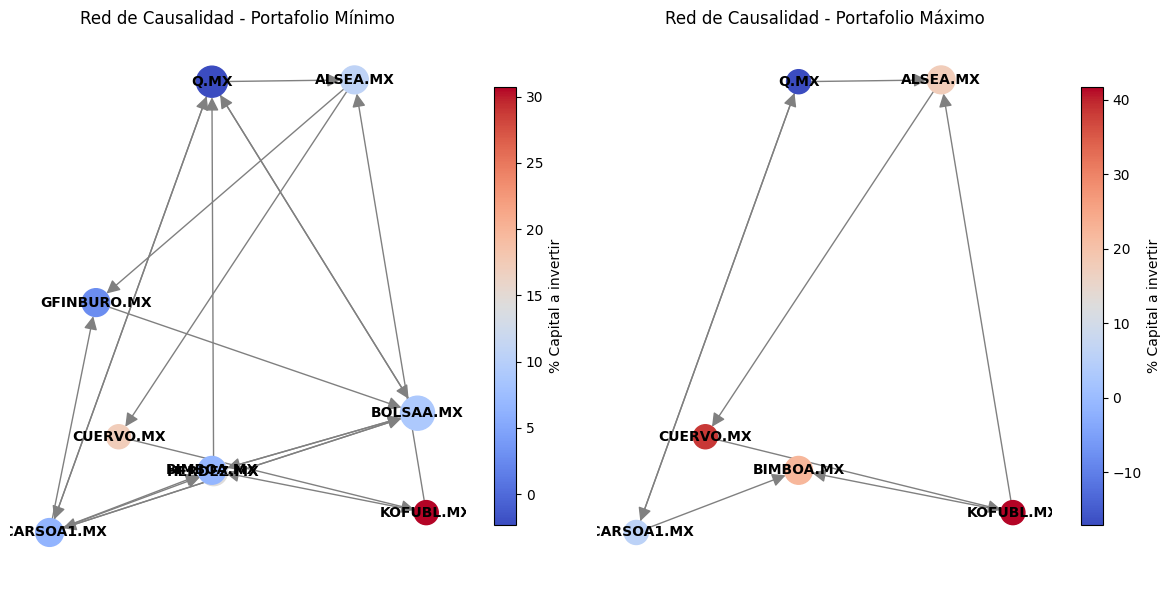

In [161]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Red de portafolio mínimo
construir_red_causalidad(
    ax=axs[0], matriz_causalidad=matriz_causalidad_portafolio_min, portfolio=portfolio_min, 
    title="Red de Causalidad - Portafolio Mínimo", 
    vmin=portfolio_min["% Capital"].min(), vmax=portfolio_min["% Capital"].max(), 
    cmap='coolwarm', pos=pos
)

# Red de portafolio máximo
construir_red_causalidad(
    ax=axs[1], matriz_causalidad=matriz_causalidad_portafolio_max, portfolio=portfolio_max, 
    title="Red de Causalidad - Portafolio Máximo", 
    vmin=portfolio_max["% Capital"].min(), vmax=portfolio_max["% Capital"].max(), 
    cmap='coolwarm', pos=pos
)

plt.tight_layout()
plt.show()